## Zadanie 1

Zbiór (niemały) logów z różnych systemów do wykorzystania w badaniach. Zwróć uwagę na licencję i cytowanie w razie wykorzystania zbioru.

Link: https://github.com/logpai/loghub

W przykładzie poniżej zostanie wykorzystany log serwera Apache ze strony wymienionej wyżej. Link do pliku sample: https://github.com/logpai/loghub/blob/master/Apache/Apache_2k.log

**Zastanów się i spróbuj przerobić to rozwiązanie tak, aby możliwe było użycie wywołań dask delayed w celu zrównoleglenia części funkcji, np. parsowanie danych w celu pobrania wartości kolumn niezależnie (tylko jednej na raz). Dane końcowe możesz zapisać do dask DataFrame, a następnie do plików parquet.**


In [20]:
from dask.distributed import Client, progress

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 31.82 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51571,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 31.82 GiB
Comm: tcp://127.0.0.1:51593,Total threads: 4
Dashboard: http://127.0.0.1:51594/status,Memory: 7.95 GiB
Nanny: tcp://127.0.0.1:51574,


In [21]:

from datetime import datetime
import time
import pandas as pd

with open('Apache_2k.log', 'r') as f:
    lines = f.readlines()

def parse(inp: str):
    record = {}
    
    date_start = inp.find('[') + 1
    date_end = inp.find(']')
    date_s = slice(date_start, date_end)

    level_start = inp.find('[', date_end) + 1
    level_end = inp.find(']', level_start)
    level_s = slice(level_start, level_end)

    client_start = inp.find('[', level_end)
    client_end = inp.find(']', client_start)

    record["date"] = inp[date_s]    
    record["level"] = inp[level_s]
    record["client"] = "" if client_start == -1 else inp[client_start + 8: client_end]
    record["message"] = inp[client_end + 2:] if record["client"] else inp[level_end + 2:]
    
    return record

def convert_date(rec):
    rec["date"] = datetime.strptime(rec["date"], "%a %b %d %H:%M:%S %Y")

    return rec


output = []

for line in lines:
    record = parse(line)
    record = convert_date(record)
    output.append(list(record.values()))
    
df = pd.DataFrame(output, columns=["date", "level", "client", "message"])
df.head()

,date,level,client,message
0,2005-12-04 04:47:44,notice,,workerEnv.init() ok /etc/httpd/conf/workers2.p...
1,2005-12-04 04:47:44,error,,mod_jk child workerEnv in error state 6\n
2,2005-12-04 04:51:08,notice,,jk2_init() Found child 6725 in scoreboard slot...
3,2005-12-04 04:51:09,notice,,jk2_init() Found child 6726 in scoreboard slot...
4,2005-12-04 04:51:09,notice,,jk2_init() Found child 6728 in scoreboard slot...


In [25]:
import dask
from dask import delayed
from datetime import datetime
import dask.dataframe as dd
import pandas as pd

with open('Apache_2k.log', 'r') as f:
    lines = f.readlines()

@delayed
def parse_date(inp: str):
    date_start = inp.find('[') + 1
    date_end = inp.find(']')
    return inp[date_start:date_end]

@delayed
def parse_level(inp: str, date_end):
    level_start = inp.find('[', date_end) + 1
    level_end = inp.find(']', level_start)
    return inp[level_start:level_end]

@delayed
def parse_client(inp: str, level_end):
    client_start = inp.find('[', level_end)
    if client_start == -1:
        return ""
    client_end = inp.find(']', client_start)
    return inp[client_start + 8: client_end]

@delayed
def parse_message(inp: str, level_end, client):
    client_end = inp.find(']', level_end)
    if client:
        return inp[client_end + 2:]
    return inp[level_end + 2:]

@delayed
def convert_date(date_str):
    return datetime.strptime(date_str, "%a %b %d %H:%M:%S %Y")

@delayed
def parse_line(line):
    date = parse_date(line)
    level = parse_level(line, line.find(']'))
    client = parse_client(line, line.find(']', line.find(']') + 1))
    message = parse_message(line, line.find(']', line.find(']') + 1), client)
    
    return {"date": date, "level": level, "client": client, "message": message}

parsed_lines = [parse_line(line) for line in lines]

@delayed
def process_record(record):
    record["date"] = convert_date(record["date"])
    return list(record.values())

processed_output = [process_record(record) for record in parsed_lines]
output = dask.compute(*processed_output)

df = pd.DataFrame(output, columns=["date", "level", "client", "message"])
df.head()

,date,level,client,message
0,Delayed('convert_date-2ad86c62-4609-455f-8010-...,Delayed('parse_level-b1db4ccc-f41f-47c9-ad66-8...,Delayed('parse_client-ebd1934f-3574-42f4-a9bc-...,Delayed('parse_message-eb71ad08-7bf7-438c-af97...
1,Delayed('convert_date-6d26cb56-bbbf-4d8f-a8c0-...,Delayed('parse_level-f8f2e2cc-6dd4-4f3c-add1-b...,Delayed('parse_client-10f8ebd0-16b0-415d-afd8-...,Delayed('parse_message-cb851007-ff7b-4299-914e...
2,Delayed('convert_date-03416a62-84d2-4fc2-84ce-...,Delayed('parse_level-2d060057-364c-48e5-a972-6...,Delayed('parse_client-1915ac4f-c3ad-4d12-a36f-...,Delayed('parse_message-7dd96fb2-8bac-4c36-8bb6...
3,Delayed('convert_date-f77d1ae3-ee44-4bb3-97d2-...,Delayed('parse_level-6996bfd3-f38b-476a-bba6-b...,Delayed('parse_client-55466184-8acd-4db3-a91e-...,Delayed('parse_message-838c10a0-7468-47e5-be6b...
4,Delayed('convert_date-0a0245f0-46ae-4240-8cd4-...,Delayed('parse_level-c78fb8f1-9bdd-444e-84e9-5...,Delayed('parse_client-70ccba62-ebf3-4ce5-ad42-...,Delayed('parse_message-196eff5e-db1b-4940-ac79...


In [26]:
import dask.dataframe as dd
import os

ddf = dd.from_pandas(df, npartitions=4)
os.makedirs('./log_parquet', exist_ok=True)
ddf.to_parquet(os.path.join('./log_parquet', 'apache_logs.parquet'))

## Zadanie Dask Futures

Zwróć uwagę na wyniki oraz widok w dashboardzie dla kilkukrotnego wywołania tych samych futures. Czy zauważyłeś coś ciekawego?

In [27]:
def func(runs: int):
    sum = 0
    for run in range(runs):
        time.sleep(2)
        sum += run
    return sum

fut = client.submit(func, 10)
fut.result()

45

In [28]:
import random

tasks = 100
futures = []

for task in range(tasks):
    futures.append(client.submit(func, random.randint(1, 15)))

results = client.gather(futures)
sum(results)

3381

In [29]:
task_list = [random.randint(1, 30) for _ in range(100)]
futures2 = client.map(func, task_list)
results2 = client.gather(futures2)
sum(results2)

16536

In [30]:
from dask.distributed import as_completed

# display(len(set(task_list)))  # kontrolnie

for num, batch in enumerate(as_completed(futures2, with_results=True).batches(), start=1):
   display(f"Batch {num}")
   for future, result in batch:
       # przetwarzaj kolejną paczkę ukończonych futures
       display(f"Future {future} result: {result}")

'Batch 1'

'Future <Future: finished, type: int, key: func-1c19ee575c36628564e46914a912411f> result: 66'

'Future <Future: finished, type: int, key: func-816c2aeb6f3bc85ea08b1584357d56e5> result: 276'

'Batch 2'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Batch 3'

'Future <Future: finished, type: int, key: func-13f0ad62ef88798a3eb337b224b9096f> result: 55'

'Future <Future: finished, type: int, key: func-76332bfcf4d44445c162f12b40904b9b> result: 253'

'Future <Future: finished, type: int, key: func-620315f9cee38568ffb707c474267307> result: 325'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-468b1d4bbd768f02b732e326cb3c1e39> result: 28'

'Batch 4'

'Future <Future: finished, type: int, key: func-8880c6054d387c23733fdfe7109e7a8c> result: 120'

'Future <Future: finished, type: int, key: func-07ce920493632c004701f1dbb28511a8> result: 406'

'Future <Future: finished, type: int, key: func-816c2aeb6f3bc85ea08b1584357d56e5> result: 276'

'Future <Future: finished, type: int, key: func-47dbab8de7cb3147009ae631cceeed8a> result: 21'

'Future <Future: finished, type: int, key: func-b49032b50832bb1a8680ee100816d382> result: 435'

'Future <Future: finished, type: int, key: func-b084e3430cfd46cf245c15cf9cc36ddf> result: 78'

'Future <Future: finished, type: int, key: func-13f0ad62ef88798a3eb337b224b9096f> result: 55'

'Future <Future: finished, type: int, key: func-620315f9cee38568ffb707c474267307> result: 325'

'Future <Future: finished, type: int, key: func-816c2aeb6f3bc85ea08b1584357d56e5> result: 276'

'Future <Future: finished, type: int, key: func-dce2320793bf324fdb8445dcb3cb1f61> result: 231'

'Future <Future: finished, type: int, key: func-e57ae0c17f12dac8a93ee88ad4929fe6> result: 0'

'Future <Future: finished, type: int, key: func-e57ae0c17f12dac8a93ee88ad4929fe6> result: 0'

'Future <Future: finished, type: int, key: func-2a878e8a0788c4eae120093633041144> result: 15'

'Future <Future: finished, type: int, key: func-8880c6054d387c23733fdfe7109e7a8c> result: 120'

'Future <Future: finished, type: int, key: func-8880c6054d387c23733fdfe7109e7a8c> result: 120'

'Future <Future: finished, type: int, key: func-2a878e8a0788c4eae120093633041144> result: 15'

'Future <Future: finished, type: int, key: func-47dbab8de7cb3147009ae631cceeed8a> result: 21'

'Future <Future: finished, type: int, key: func-620315f9cee38568ffb707c474267307> result: 325'

'Future <Future: finished, type: int, key: func-816c2aeb6f3bc85ea08b1584357d56e5> result: 276'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-62b4e0012cc4bf1f559ac3c6d83327a7> result: 153'

'Future <Future: finished, type: int, key: func-79e992313a2ea7d4f274a72197c07eaa> result: 300'

'Future <Future: finished, type: int, key: func-eba18ae3b3ed99083ac845a44b500024> result: 36'

'Future <Future: finished, type: int, key: func-43b6d26b6b9939a8d33a235708080d37> result: 105'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-7dc2a0352e59de8de60655f054b9d34c> result: 171'

'Future <Future: finished, type: int, key: func-43b6d26b6b9939a8d33a235708080d37> result: 105'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-92b07e28cf4f18cf125fe855e93b6fc1> result: 378'

'Future <Future: finished, type: int, key: func-468b1d4bbd768f02b732e326cb3c1e39> result: 28'

'Future <Future: finished, type: int, key: func-5d4711d4014fbcd5eed8ddb4309f3f55> result: 190'

'Future <Future: finished, type: int, key: func-468b1d4bbd768f02b732e326cb3c1e39> result: 28'

'Future <Future: finished, type: int, key: func-5855603231b69ce55bdecac66619be13> result: 91'

'Future <Future: finished, type: int, key: func-62b4e0012cc4bf1f559ac3c6d83327a7> result: 153'

'Future <Future: finished, type: int, key: func-eba18ae3b3ed99083ac845a44b500024> result: 36'

'Future <Future: finished, type: int, key: func-43b6d26b6b9939a8d33a235708080d37> result: 105'

'Future <Future: finished, type: int, key: func-dd3384d945e40e0aa29a98de762de76d> result: 6'

'Future <Future: finished, type: int, key: func-7dc2a0352e59de8de60655f054b9d34c> result: 171'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-2f86059c4e16422a4ec5b4769e1d073c> result: 10'

'Future <Future: finished, type: int, key: func-d1ec18113530de218023e4c1e6420493> result: 45'

'Future <Future: finished, type: int, key: func-1c19ee575c36628564e46914a912411f> result: 66'

'Future <Future: finished, type: int, key: func-62b4e0012cc4bf1f559ac3c6d83327a7> result: 153'

'Future <Future: finished, type: int, key: func-468b1d4bbd768f02b732e326cb3c1e39> result: 28'

'Future <Future: finished, type: int, key: func-b49032b50832bb1a8680ee100816d382> result: 435'

'Future <Future: finished, type: int, key: func-92b07e28cf4f18cf125fe855e93b6fc1> result: 378'

'Future <Future: finished, type: int, key: func-d1ec18113530de218023e4c1e6420493> result: 45'

'Future <Future: finished, type: int, key: func-79e992313a2ea7d4f274a72197c07eaa> result: 300'

'Future <Future: finished, type: int, key: func-dce2320793bf324fdb8445dcb3cb1f61> result: 231'

'Future <Future: finished, type: int, key: func-7de22011fd0cbb5bb552fbd734c0cf93> result: 3'

'Future <Future: finished, type: int, key: func-b084e3430cfd46cf245c15cf9cc36ddf> result: 78'

'Future <Future: finished, type: int, key: func-7dc2a0352e59de8de60655f054b9d34c> result: 171'

'Future <Future: finished, type: int, key: func-1c19ee575c36628564e46914a912411f> result: 66'

'Future <Future: finished, type: int, key: func-5855603231b69ce55bdecac66619be13> result: 91'

'Future <Future: finished, type: int, key: func-816c2aeb6f3bc85ea08b1584357d56e5> result: 276'

'Future <Future: finished, type: int, key: func-79e992313a2ea7d4f274a72197c07eaa> result: 300'

'Future <Future: finished, type: int, key: func-eba18ae3b3ed99083ac845a44b500024> result: 36'

'Future <Future: finished, type: int, key: func-1c19ee575c36628564e46914a912411f> result: 66'

'Future <Future: finished, type: int, key: func-62b4e0012cc4bf1f559ac3c6d83327a7> result: 153'

'Future <Future: finished, type: int, key: func-79e992313a2ea7d4f274a72197c07eaa> result: 300'

'Future <Future: finished, type: int, key: func-5d4711d4014fbcd5eed8ddb4309f3f55> result: 190'

'Future <Future: finished, type: int, key: func-8880c6054d387c23733fdfe7109e7a8c> result: 120'

'Future <Future: finished, type: int, key: func-9f345cca5a2a7c4130573772f534adcf> result: 136'

'Future <Future: finished, type: int, key: func-7dc2a0352e59de8de60655f054b9d34c> result: 171'

'Future <Future: finished, type: int, key: func-9f345cca5a2a7c4130573772f534adcf> result: 136'

'Future <Future: finished, type: int, key: func-79e992313a2ea7d4f274a72197c07eaa> result: 300'

'Future <Future: finished, type: int, key: func-76332bfcf4d44445c162f12b40904b9b> result: 253'

'Future <Future: finished, type: int, key: func-b084e3430cfd46cf245c15cf9cc36ddf> result: 78'

'Future <Future: finished, type: int, key: func-afdc00efcf9b82f42a48e180b16e8d3f> result: 351'

'Future <Future: finished, type: int, key: func-5d4711d4014fbcd5eed8ddb4309f3f55> result: 190'

'Future <Future: finished, type: int, key: func-2a878e8a0788c4eae120093633041144> result: 15'

'Future <Future: finished, type: int, key: func-b49032b50832bb1a8680ee100816d382> result: 435'

'Future <Future: finished, type: int, key: func-24cd6ba9d797b4d5e28963b5a28305ba> result: 1'

'Future <Future: finished, type: int, key: func-b49032b50832bb1a8680ee100816d382> result: 435'

'Future <Future: finished, type: int, key: func-92b07e28cf4f18cf125fe855e93b6fc1> result: 378'

'Future <Future: finished, type: int, key: func-13f0ad62ef88798a3eb337b224b9096f> result: 55'

'Future <Future: finished, type: int, key: func-13f0ad62ef88798a3eb337b224b9096f> result: 55'

'Future <Future: finished, type: int, key: func-eba18ae3b3ed99083ac845a44b500024> result: 36'

'Future <Future: finished, type: int, key: func-1c19ee575c36628564e46914a912411f> result: 66'

'Future <Future: finished, type: int, key: func-e57ae0c17f12dac8a93ee88ad4929fe6> result: 0'

'Future <Future: finished, type: int, key: func-47dbab8de7cb3147009ae631cceeed8a> result: 21'

'Future <Future: finished, type: int, key: func-79e992313a2ea7d4f274a72197c07eaa> result: 300'

'Future <Future: finished, type: int, key: func-79e992313a2ea7d4f274a72197c07eaa> result: 300'

'Future <Future: finished, type: int, key: func-43b6d26b6b9939a8d33a235708080d37> result: 105'

'Future <Future: finished, type: int, key: func-b084e3430cfd46cf245c15cf9cc36ddf> result: 78'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-620315f9cee38568ffb707c474267307> result: 325'

'Future <Future: finished, type: int, key: func-dce2320793bf324fdb8445dcb3cb1f61> result: 231'

'Future <Future: finished, type: int, key: func-4394c55205c9dab823dc3ab04a76dc3e> result: 210'

'Future <Future: finished, type: int, key: func-b49032b50832bb1a8680ee100816d382> result: 435'

'Future <Future: finished, type: int, key: func-d1ec18113530de218023e4c1e6420493> result: 45'

In [31]:
client.who_has(futures2)

Key,Copies,Workers
func-13f0ad62ef88798a3eb337b224b9096f,1,tcp://127.0.0.1:51590
func-9f345cca5a2a7c4130573772f534adcf,1,tcp://127.0.0.1:51590
func-eba18ae3b3ed99083ac845a44b500024,1,tcp://127.0.0.1:51596
func-5855603231b69ce55bdecac66619be13,1,tcp://127.0.0.1:51593
func-dd3384d945e40e0aa29a98de762de76d,1,tcp://127.0.0.1:51593
func-2f86059c4e16422a4ec5b4769e1d073c,1,tcp://127.0.0.1:51590
func-47dbab8de7cb3147009ae631cceeed8a,1,tcp://127.0.0.1:51590
func-24cd6ba9d797b4d5e28963b5a28305ba,1,tcp://127.0.0.1:51597
func-76332bfcf4d44445c162f12b40904b9b,1,tcp://127.0.0.1:51596
func-1c19ee575c36628564e46914a912411f,1,tcp://127.0.0.1:51597


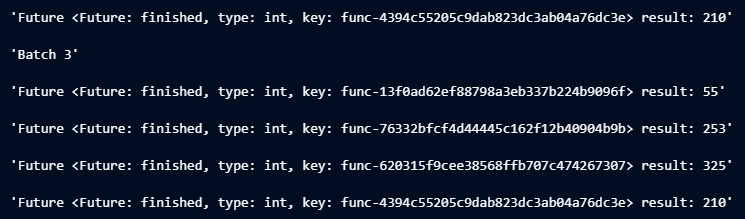

Tak jak widać wyżej, futures o tych samych wynikach to te same wyliczenia, Dask nie wykonuje tego samego kilkukrotnie, wykorzystuje wyniki z cache.

## Zadanie 2
Wykorzystując przykłady zaprezentowane w labie wykonaj na danych people (możesz zmniejszyć lub zwiększyć ich wolumen w zależności od potrzeb) operację z użyciem Dask bag, która polegać będzie na przetworzeniu wszystkich plików i zapisaniu do plików o nazwie expired_{partition}.json rekordów, których ważność karty kredytowej wygasła (jest to wartość w formacie miesiąc/rok). Zapisując ustaw finalną liczbę plików na 10 jeżeli była inna. Możesz to zrobić poprzez zmianę ilość partycji dask bag (patrz link do API na początku laba).

In [1]:
from dask.distributed import Client
import dask
import dask.bag as db
import json
import os

# client = Client(n_workers=4)

DATAPATH = './data'
os.makedirs(DATAPATH, exist_ok=True)

b = dask.datasets.make_people(npartitions=100, records_per_partition=10000)

def expired_credit_card(record):
    expiry_date = record.get('cc_exp', '00/00')  # format miesiąc/rok
    month, year = map(int, expiry_date.split('/'))
    return (year < 2024) or (year == 2024 and month < 10)

expired_records = b.filter(expired_credit_card)

In [2]:
expired_records = expired_records.repartition(10)
expired_records.map(json.dumps).to_textfiles(os.path.join(DATAPATH, 'expired_*.json'))

['c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_0.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_1.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_2.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_3.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_4.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_5.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_6.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_7.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_8.json',
 'c:/Users/karol/GitHub/analiza_duzych_zbiorow_danych/lab03/data/expired_9.json']

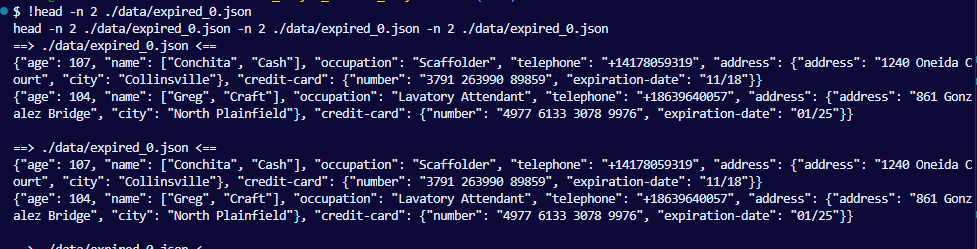

## Zadanie 3
Wybierając z danych people dane tylko osób dorosłych (zaprezentowane w przykładach w tym labie) przechowaj je w obiekcie typu bag, a następnie zapisz je do dask dataframe za pomocą metody to_dataframe (pamiętaj o tym jaka jest aktualna struktura pojedynczego rekordu), a następnie zapisz do jednego pliku w formacie parquet.

In [8]:
from dask.distributed import Client
import dask
import dask.bag as db
import dask.dataframe as dd
import os
import json

# client = Client(n_workers=4)
b = dask.datasets.make_people(npartitions=100, records_per_partition=10000)

def is_adult(record):
    return record.get('age', 0) >= 18

adults = b.filter(is_adult)

df = adults.to_dataframe()
df_single_partition = df.repartition(npartitions=1)
df_single_partition.to_parquet('./data/adults_data.parquet', write_index=False)

In [6]:
df.head()

,age,name,occupation,telephone,address,credit-card
0,47,"('Gilberte', 'Rich')",Auxiliary Nurse,+17528614872,"{'address': '369 Catalina Parkway', 'city': 'M...","{'number': '3720 452992 74865', 'expiration-da..."
1,24,"('Kizzie', 'Humphrey')",Bodyshop,+1-713-570-6288,"{'address': '1079 Hobart Manor', 'city': 'Lanc...","{'number': '2450 1290 7746 0648', 'expiration-..."
2,47,"('Lashaun', 'Arnold')",Radio Director,+1-628-025-3451,"{'address': '1027 Hooker Freeway', 'city': 'St...","{'number': '5107 2915 6759 0134', 'expiration-..."
3,92,"('Virgilio', 'Foreman')",Tax Inspector,+17026138589,"{'address': '83 Lapham Mews', 'city': 'Washing...","{'number': '5439 7019 5629 4733', 'expiration-..."
4,23,"('Eric', 'Francis')",Receptionist,+1-802-904-8338,"{'address': '384 East Street', 'city': 'Gadsden'}","{'number': '5409 0310 6267 4115', 'expiration-..."


## 4. Lokalny klaster w pracowni komputerowej.
Scenariusz skonfigurowania i przetestowania klastra w pracowni komputerowej zakłada:

zdefiniowanie jednego lub kilku maszyn jako schedulerów klastra Dask (można część zasobów skonfigurować jednocześnie jako worker),
podłączenie do schedulera workerów poprzez sieć lokalną, które są uruchomione na maszynach w pracowni komputerowej,
wykonanie kilku zadań o zróżnicowanym stopniu skomplikowania i wykorzystania zasobów na skonfigurowanym klastrze.
### 4.1 Wstępne wymagania elementów klastra.
Dask (oraz większość systemów tego typu) zaleca, aby poszczególne elementy klastra zostały skonfigurowane na tej samej wersji środowiska obliczeniowego. W związku z tym zarówno na maszynie będącej schedulerem jak i na workerach należy przygotować środowisko wirtualne Pythona z tą samą wersją interpretera.
Dokumentacja dla CLI dask poniższych poleceń: https://docs.dask.org/en/latest/deploying-cli.html

#### Krok 1.
Przygotowanie środowiska wirtualnego na wszystkich maszynach, które mają być częścią klastra:
instalujemy interpreter Pythona w tej samej wersji,
instalujemy również moduł dask distributed,
#### Krok 2
Uruchamiamy scheduler. Na wybranej maszynie (maszynach) uruchamiamy scheduler za pomocą polecenia `dask-scheduler` w konsoli Pythona z aktywowanym środowiskiem wirtualnym. Można równiez uruchomić scheduler w sposób przedstawiany do tej porty w załączonych notebookach. Notujemy adres IP oraz port, na którym działa scheduler klastra dask.
#### Krok 3
Dołączamy kolejne workery do klastra. W konsoli Python pozostałych maszyn, z aktywowanym środowiskiem wirtualnym Python, uruchamiamy workery poleceniem `dask-worker 192.168.1.1:8786 --nprocs 1 --nthreads 1 --memory-limit 2GB`, ustawiając odpowiedni adres IP oraz ilość procesów, wątków dla każdego workera.
#### rok 4
Z poziomu schedulera uruchamiamy zadania i śledzimy ich wykonanie w dashboardzie.

In [ ]:
# wspólne środowisko: Python 3.12.1 + pip install dask distributed
# polecenie uruchamiania workerów: dask worker 192.168.20.15:8786 --nworkers 2 --nthreads 2 --memory-limit 2GB

### 4.2 Scenariusze wykorzystania klastra.
#### Scenariusz 1
Uruchomienie pierwszego testowego zadania polegającego na przetworzeniu stosunkowo dużej tablicy dask na dostępnych workerach. Pamiętaj, że tworząc obiekt klienta możesz wskazać ile workerów chcesz wykorzystać na tym kliencie i to nie musi być całość dostępnych zasobów. Ważne jest również prześledzenie utylizacji workerów oraz struktury zadań (np. transfer danych między workerami) w dashboardzie. Dopasuj wielkość tablicy tak, aby wykorzystać dostępną pamięć RAM klastra w dość znacznym stopniu.

#### Scenariusz 2
W tym zadaniu należy przygotować wybrany zbiór danych na komputerze, na którym uruchomiony został scheduler i wykonać proces wczytania danych do wybranej kolekcji dask w sposób rozproszony. Ponownie monitoruj sposób pracy klastra w dashboardzie. Pierwsze uruchomienie powinno odbyć się na stosunkowo niewielkiej liczbie danych, z czasem należy ją zwiększyć tak, aby klaster był faktycznie zajęty czymś przez pewien czas (np. kilka minut). Tu można przywołać zadania z poprzedniego labu z danymi ze zbioru private_instagram lub zbiorami przedstawionymi w tym labie.